In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch
import numpy as np
import os.path as op
import torch.nn.functional as F
from datasets import build_dataloader
from utils.checkpoint import Checkpointer
from model import build_model
from utils.metrics import Evaluator
from utils.iotools import load_train_configs
# import random
import argparse
# import matplotlib.pyplot as plt
# from PIL import Image
from datasets.rstpreid import RSTPReid
from utils.logger import setup_logger
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from matplotlib import gridspec

D:\Anaconda3\envs\Image-Text\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
D:\Anaconda3\envs\Image-Text\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
parser = argparse.ArgumentParser(description="McRSA Test")
dataset_dir = r'F:\DataSet\CrossModalRetrieval\Image_Text'
root_dir = r'F:\result_TMM\Visualization'

pretrain_set = 'CUHK-PEDES' # CUHK-PEDES, RSTPReid, Flickr_30k, MSCOCO
premodel = os.path.join(root_dir, pretrain_set)

Method = 'McRSA'#McRSR
weightLib = {'IRRA':'68.78irra_30756',
            'McRSA':'69.12_bs32_37056_2'}

Pretrain_Lib = {'RSTPReid': '58.65_bs256_37056_2',
                'CUHK-PEDES': weightLib[Method],
                'Flickr_30k': '61.87_bs256_37056_2'}


weigt_fileName = Pretrain_Lib[pretrain_set]
test_path = os.path.join(premodel, Method + '/' + weigt_fileName)

path_test = os.path.join(premodel, test_path + '/' + 'configs.yaml')
parser.add_argument("--config_file", default=path_test)
args = parser.parse_args(args=[])
args = load_train_configs(args.config_file)
args.dataset_name = pretrain_set 
args.root_dir = dataset_dir
args.output_dir = os.path.join(root_dir, test_path)

args.training = False
logger = setup_logger('McRSA', save_dir=args.output_dir, if_train=args.training)
logger.info(args)
# device = "cuda"
device = 'cuda' if torch.cuda.is_available()  else 'cpu'

test_img_loader, test_txt_loader, num_classes = build_dataloader(args)
model = build_model(args, num_classes=num_classes)
checkpointer = Checkpointer(model)
checkpointer.load(f=op.join(args.output_dir, 'best.pth'))
model.to(device)
evaluator = Evaluator(test_img_loader, test_txt_loader)

qfeats, gfeats, qids, gids = evaluator._compute_embedding(model.eval())
# 归一化特征
text_features  = qfeats.cpu().detach().numpy() # F.normalize(qfeats, p=2, dim=1).cpu().detach().numpy()  # 文本特征
image_features = gfeats.cpu().detach().numpy() # F.normalize(gfeats, p=2, dim=1).cpu().detach().numpy()  # 图像特征

2025-02-21 23:10:18,844 McRSA INFO: {'MLM': True, 'alpha': 0.9, 'batch_size': 32, 'beta': 0.999, 'bias_lr_factor': 2.0, 'cmt_depth': 4, 'dataset_name': 'CUHK-PEDES', 'distributed': False, 'eval_period': 1, 'gamma': 0.1, 'id_loss_weight': 1.0, 'img_aug': False, 'img_size': (384, 128), 'local_rank': 0, 'log_period': 300, 'loss_names': 'ppe+mcu+fsa', 'lr': 1e-05, 'lr_factor': 5.0, 'lrscheduler': 'cosine', 'masked_token_rate': 0.8, 'masked_token_unchanged_rate': 0.1, 'milestones': (20, 50), 'mlm_loss_weight': 1.0, 'momentum': 0.9, 'name': 'baseline', 'num_epoch': 30, 'num_instance': 4, 'num_workers': 16, 'optimizer': 'Adam', 'output_dir': 'F:\\result_TMM\\Visualization\\CUHK-PEDES\\McRSA/69.12_bs32_37056_2', 'power': 0.9, 'pretrain_choice': 'ViT-B/16', 'resume': False, 'resume_ckpt_file': '', 'root_dir': 'F:\\DataSet\\CrossModalRetrieval\\Image_Text', 'sampler': 'random', 'stride_size': 16, 'target_lr': 0, 'temperature': 0.02, 'test_batch_size': 16, 'text_length': 77, 'training': False, 'v

D:\Anaconda3\envs\Image-Text\lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
D:\Anaconda3\envs\Image-Text\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


2025-02-21 23:11:57,118 McRSA.eval INFO: Average time per iteration: 0.0139 s / it


In [5]:
from tqdm import tqdm
test_images = []
test_texts = []
for _1, img in tqdm(test_img_loader):
    img_np = img.cpu().detach().numpy()
    test_images.append(img_np)

# 提取文本特征
for _2, txt in tqdm(test_txt_loader):
    txt_np = txt.cpu().detach().numpy()
    test_texts.append(txt_np)

100%|████████████████████████████████████████████████████████████████████████████████| 385/385 [00:39<00:00,  9.87it/s]


### 原始图像特征降维

In [6]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from PIL import Image

# 检查 CUDA 是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载预训练的 ResNet50 并去掉分类层
model = models.resnet50(weights=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # 去掉最后的全连接层
model.to(device)  # 将模型移动到 GPU
model.eval()

# 图像预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 根据需要调整尺寸
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 处理图像数据，假设 test_images 是一个列表，每个元素是 (batch, 3, 384, 128) 的数组
preprocessed_images = []

for batch in test_images:
    transformed_batch = []
    for img in batch:
        img_pil = Image.fromarray(np.transpose(img, (1, 2, 0)).astype(np.uint8))  # 转换为 PIL 图像
        transformed_img = transform(img_pil).unsqueeze(0).to(device)  # 转换并移动到 GPU
        transformed_batch.append(transformed_img)
    preprocessed_images.append(torch.cat(transformed_batch))  # 使用 cat 而不是 stack 以确保正确的维度

# 创建数据加载器
data_loader = DataLoader(TensorDataset(torch.cat(preprocessed_images).to(device)), batch_size=32, shuffle=False)  # 移动到 GPU

# 提取特征
padded_images = []
with torch.no_grad():
    for images in data_loader:
        images = images[0].to(device)  # 将数据移动到 GPU
        feature_batch = model(images)  # 提取特征
        padded_images.append(feature_batch.squeeze(-1).squeeze(-1).cpu())  # 去掉多余的维度，并移动回 CPU

D:\Anaconda3\envs\Image-Text\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# 对文本特征进行同样的操作
max_txt_shape = [max([txt.shape[i] for txt in test_texts]) for i in range(len(test_texts[0].shape))]

padded_texts = []
for txt in test_texts:
    while len(txt.shape) < len(max_txt_shape):
        txt = np.expand_dims(txt, axis=-1)

    pad_width = [(0, max_dim - txt_dim) for txt_dim, max_dim in zip(txt.shape, max_txt_shape)]
    padded_txt = np.pad(txt, pad_width, mode='constant')
    padded_texts.append(padded_txt)

# 使用 vstack 合并特征
test_images = torch.cat(padded_images).numpy()
test_texts = np.vstack(padded_texts)

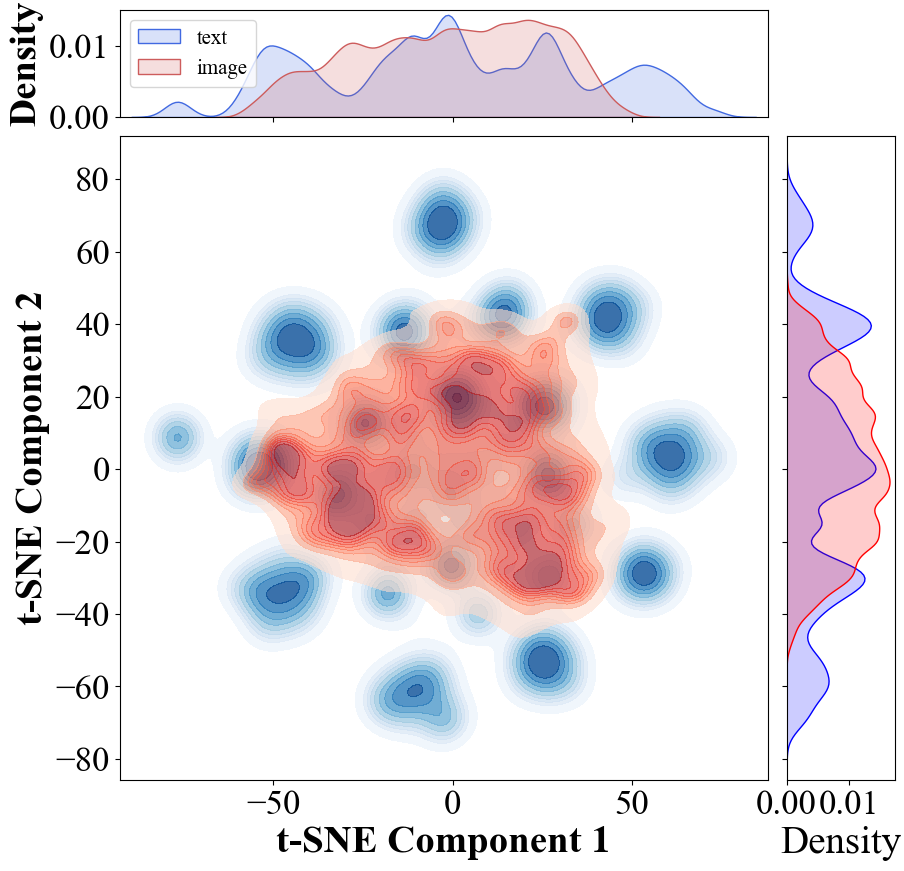

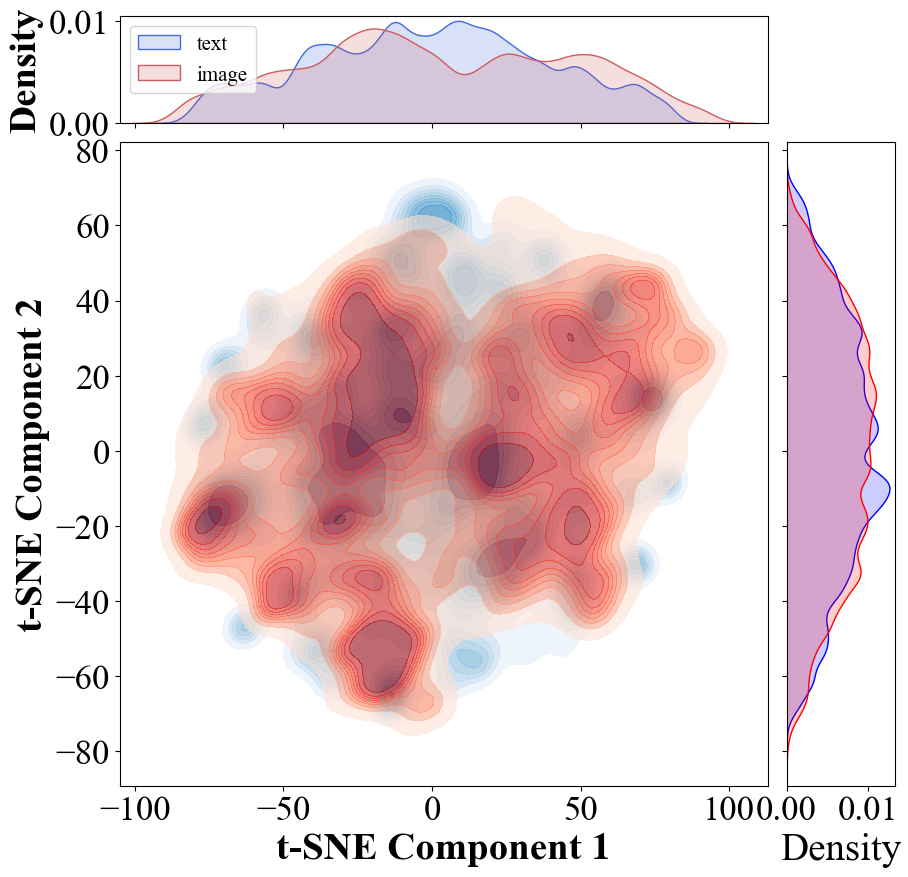

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import gridspec
from sklearn.manifold import TSNE

# 设置全局字体为 Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# 函数：绘制主图和子图（分别为横轴和纵轴的概率密度分布）
def plot_tsne_with_marginal_kde(features1, features2, 
                                fontsize_xyAxes=20, fontsize_tick=18, 
                                alpha=0.2, subfig_width=0.2, 
                                bw_adjust = 0.1, imgNAME = None):
    # 使用白色背景
#     plt.style.use('seaborn-white')
# plt.yticks(fontproperties='Times New Roman', size=15,weight='bold')
    # 使用 t-SNE 降维
    tsne1 = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=0)
    tsne2 = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=0)
    reduced_features1 = tsne1.fit_transform(features1)
    reduced_features2 = tsne2.fit_transform(features2)

    x1 = reduced_features1[:, 0]
    y1 = reduced_features1[:, 1]
    x2 = reduced_features2[:, 0]
    y2 = reduced_features2[:, 1]

    # 创建主图与子图布局
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(2, 2, width_ratios=[6, 1], height_ratios=[1, 6], wspace=0.05, hspace=0.05)  
    # 主图
    ax_main = plt.subplot(gs[1, 0])
    ax1 = sns.kdeplot(x=x1, y=y1, cmap='Blues', fill=True, bw_adjust=bw_adjust, alpha=0.8, label='Text Features', ax=ax_main)
    ax2 = sns.kdeplot(x=x2, y=y2, cmap='Reds', fill=True, bw_adjust=bw_adjust, alpha=0.6, label='Image Features', ax=ax_main)
    ax_main.set_xlabel("t-SNE Component 1", fontsize=fontsize_xyAxes, fontweight='bold')
    ax_main.set_ylabel("t-SNE Component 2", fontsize=fontsize_xyAxes, fontweight='bold')
#     ax_main.legend(labels=['text', 'image'], fontsize=int(fontsize_tick*0.6))  # 显示图例
#     ax_main.set_title(title, fontsize=fontsize)
    ax_main.set_facecolor('white')  # 设置主图背景为白色

    # 上侧子图（X轴的概率密度分布）
    ax_xdist = plt.subplot(gs[0, 0], sharex=ax_main)
    sns.kdeplot(x=x1, color='royalblue', fill=True, bw_adjust=bw_adjust, alpha=alpha, ax=ax_xdist)
    sns.kdeplot(x=x2, color='indianred', fill=True, bw_adjust=bw_adjust, alpha=alpha, ax=ax_xdist)
    ax_xdist.set_ylabel("Density", fontsize= fontsize_xyAxes, fontweight='bold')#int(fontsize_xyAxes*0.5)
    ax_xdist.set_facecolor('white')  # 子图背景设为白色
    ax_xdist.legend(labels=['text', 'image'], fontsize=int(fontsize_tick*0.6), loc='upper left')
    plt.setp(ax_xdist.get_xticklabels(), visible=False)
    
    
    # 右侧子图（Y轴的概率密度分布）
    ax_ydist = plt.subplot(gs[1, 1], sharey=ax_main)
    sns.kdeplot(y=y1, color='blue', fill=True, bw_adjust=bw_adjust, alpha=alpha, ax=ax_ydist)
    sns.kdeplot(y=y2, color='red', fill=True, bw_adjust=bw_adjust, alpha=alpha, ax=ax_ydist)
    ax_ydist.set_xlabel("Density", fontsize= fontsize_xyAxes)
    ax_ydist.set_facecolor('white')  # 子图背景设为白色
    plt.setp(ax_ydist.get_yticklabels(), visible=False)

    # 调整所有子图的字体大小
    ax_xdist.tick_params(axis='both', which='major', labelsize=fontsize_tick)
    ax_ydist.tick_params(axis='both', which='major', labelsize=fontsize_tick)
    ax_main.tick_params(axis='both', which='major',  labelsize=fontsize_tick)

    # 显示图形
#     plt.legend()
    # 保存主图和子图为矢量图
    plt.savefig(r'./results/clusters' + '/'+ imgNAME +'.svg', format='svg', bbox_inches='tight')
    plt.show()

fontsize_xyAxes = 28
fontsize_tick = 25
plot_tsne_with_marginal_kde(test_texts, test_images, 
                            fontsize_xyAxes=fontsize_xyAxes, 
                            fontsize_tick=fontsize_tick, bw_adjust = 0.5, 
                            alpha= 0.2, imgNAME = 'TNSE_raw')
plot_tsne_with_marginal_kde(text_features, image_features, 
                            fontsize_xyAxes=fontsize_xyAxes, 
                            fontsize_tick=fontsize_tick, bw_adjust = 0.5, 
                            alpha= 0.2, imgNAME = 'TNSE_Mc')